# Reef Futures Notebook

This Notebook is used to prepare the data used for the talk, "Multi-view Label Classification in Viscore and TagLab for Precise and Efficient Estimates of Coral Cover using Large-area Imaging Data". 

#### Imports

In [1]:
import os
import io
import gc
import glob
import json
import random
import uuid

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

from PIL import Image
import rasterio
from rasterio.windows import Window

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)


#### Functions

In [2]:
def get_path_from_image_point_file(file_path):
    with open(file_path, 'r') as file:
        # Read the first line (header)
        header = next(file).strip().split(',')
        
        # Read the second line (first data row)
        first_data_line = next(file).strip()
        
        # Skip empty rows and grab the next non-empty row
        while not first_data_line:
            first_data_line = next(file).strip()
        
        # Split the non-empty row into a list
        first_data_line = first_data_line.split(',')
    
    # Create a DataFrame with the header and the first non-empty data row
    df = pd.DataFrame([first_data_line], columns=header)
    
    return os.path.dirname(df['Name'][0])


def modify_header_and_convert_to_df(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Modify the header line (line 0) by appending a comma
    lines[0] = lines[0].strip() + ',\n'
    
    # Join the lines back together to form a single string
    modified_csv_string = ''.join(lines)
    
    # Use pandas to read the modified string as a CSV
    df = pd.read_csv(io.StringIO(modified_csv_string))
    
    return df

In [3]:
def filter_orthomosaic_csv_file(csv_file):
    """
    Filter the CSV Files based on the mapping dictionary.
    """
    filtered_dfs = modify_header_and_convert_to_df(csv_file)
    filtered_dfs['Name'] = os.path.basename(csv_file).split(".csv")[0]
    
    filtered_dfs.drop(filtered_dfs[filtered_dfs['Label'] == 'drop'].index, inplace=True)
    filtered_dfs = filtered_dfs[['Name', 'Label', 'Row', 'Column']]
    filtered_dfs.dropna(inplace=True)
    filtered_dfs.reset_index(drop=True, inplace=True)
    filtered_dfs['Row'] = filtered_dfs['Row'].astype(int)
    filtered_dfs['Column'] = filtered_dfs['Column'].astype(int)
    
    return filtered_dfs

def filter_image_csv_file(csv_file, views=1):
    """
    Filter the CSV Files based on the mapping dictionary.
    """
    filtered_dfs = pd.read_csv(csv_file)
    filtered_dfs['Name'] = filtered_dfs['Name'].map(os.path.basename)
    
    filtered = []
    for dot in filtered_dfs['Dot'].unique():
        subset = filtered_dfs[filtered_dfs['Dot'] == dot]
        # Calculate the mean of the reprojection error
        mean = subset['ReprojectionError'].mean()
        # Filter the subset to get only rows with reprojection error less than the mean
        subset = subset[subset['ReprojectionError'] <= mean]
        # Get the new mean and std
        std = subset['ReprojectionError'].std()
        mean = subset['ReprojectionError'].mean()
        # Subset to get only rows within +/- one standard deviation of the mean
        subset = subset[(subset['ReprojectionError'] >= (mean - std)) & 
                        (subset['ReprojectionError'] <= (mean + std))]
        # Sort based on reprpjection error and ViewIndex, ascending
        subset = subset.sort_values(['ReprojectionError', 'ViewIndex'], ascending=[True, True])
        # Get the first N views
        subset = subset.head(views)
        filtered.append(subset)
        
    filtered_dfs = pd.concat(filtered)
    filtered_dfs.dropna(inplace=True)
    filtered_dfs.reset_index(drop=True, inplace=True)
    filtered_dfs['Row'] = filtered_dfs['Row'].astype(int)
    filtered_dfs['Column'] = filtered_dfs['Column'].astype(int)
    
    return filtered_dfs

In [16]:
def create_class_mapping_json(dataframe, directory):
    """
    Outputs a JSON file with the class mapping.
    Class mapping is a dictionary with the class name as the
    key, which contains a dictionary containing short_code_label,
    long_code_label, id (uuid), and color [R, G, B].
    """
    class_mapping = {}
    for label in dataframe['Label'].unique():
        if label not in class_mapping:
            class_mapping[label] = {
                "short_label_code": label,
                "short_label_code": label,
                "id": str(uuid.uuid4()),
                "color": [np.random.randint(0, 255) for _ in range(3)] + [255]
            }
    with open(f"{directory}/class_mapping.json", "w") as f:
        json.dump(class_mapping, f, indent=4)

In [5]:
def plot_dataframes(dataframes, split, directory):
    """
    Combines a list of dataframes and saves them as a CSV file.
    Plots a distribution of the labels.
    """
    combined_df = pd.concat(dataframes)
    
    plt.figure(figsize=(20, 20))
    combined_df['Label'].value_counts().plot(kind='bar', title=f"{split} Label Distribution")
    plt.savefig(f"{directory}/{split}_label_distribution.png")
    
def save_dataframe(dataframe, site_name, directory):
    """
    Save the dataframe to a CSV file.
    """
    dataframe.to_csv(f"{directory}/{site_name}.csv", index=False)

In [6]:
def create_cropped_image(rasterio_src, annotation_size, row, column):
    half_size = annotation_size // 2
    pixel_x, pixel_y = int(column), int(row)
    window = Window(
        col_off=max(0, pixel_x - half_size),
        row_off=max(0, pixel_y - half_size),
        width=min(rasterio_src.width - (pixel_x - half_size), annotation_size),
        height=min(rasterio_src.height - (pixel_y - half_size), annotation_size)
    )
    
    data = rasterio_src.read(window=window)
    
    if data.shape[0] == 3:
        data = np.transpose(data, (1, 2, 0))
    elif data.shape[0] == 1:
        data = np.squeeze(data)
    
    if data.dtype != np.uint8:
        data = ((data - data.min()) / (data.max() - data.min()) * 255).astype(np.uint8)
    
    return Image.fromarray(data)

def process_annotation_chunk(src, annotations_chunk, size, dataset_dir, split):
    results = []
    for _, annotation in annotations_chunk.iterrows():
        label = annotation['Label']
        row, column = annotation['Row'], annotation['Column']
        output_path = os.path.join(dataset_dir, split, label)
        os.makedirs(output_path, exist_ok=True)
        output_filename = f"{label}_{row}_{column}_{uuid.uuid4()}.jpg"
        full_output_path = os.path.join(output_path, output_filename)
        
        try:
            cropped_image = create_cropped_image(src, size, row, column)
            if cropped_image:
                results.append((cropped_image, full_output_path))
        except Exception as e:
            print(f"ERROR: Issue processing annotation at row {row}, column {column}: {e}")
    
    return results

def process_image_batch(image_path, annotations, size, dataset_dir, split, chunk_size=100):
    with rasterio.open(image_path) as src:
        for i in range(0, len(annotations), chunk_size):
            chunk = annotations.iloc[i:i+chunk_size]
            chunk_results = process_annotation_chunk(src, chunk, size, dataset_dir, split)
            save_images(chunk_results)
            del chunk_results
            gc.collect()

def save_images(cropped_images):
    for image, path in cropped_images:
        try:
            image.save(path, format='JPEG', optimize=True, quality=85)
        except Exception as e:
            print(f"ERROR: Issue saving image {path}: {e}")
            png_path = path.replace(".jpg", ".png")
            image.save(png_path, optimize=True)
        finally:
            image.close()

def create_dataset(image_paths, dataframe, size, class_labels, dataset_dir, split, chunk_size=1000):
    
    # Create blank JPEGs for each class
    for label in class_labels:
        os.makedirs(f"{dataset_dir}/{split}/{label}", exist_ok=True)
        img = np.zeros((size, size, 3), dtype=np.uint8)
        Image.fromarray(img).save(f"{dataset_dir}/{split}/{label}/NULL.jpg", format='JPEG', optimize=True, quality=85)
        
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = []
        for image_path in image_paths:
            image_basename = os.path.basename(image_path)
            annotations = dataframe[dataframe['Name'] == image_basename]
            future = executor.submit(process_image_batch, 
                                     image_path, 
                                     annotations, 
                                     size, 
                                     dataset_dir, 
                                     split,
                                     chunk_size)
            futures.append(future)
        
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {split} images"):
            try:
                future.result()
            except Exception as exc:
                print(f'An image generated an exception: {exc}')

#### Directory Structure

In [7]:
root = r"L:/Analysis/Jordan_AI"
study_dir = f"{root}/preliminary_study"

singleview_dir = f"{study_dir}/SingleView"
singleview_dataset_dir = f"{singleview_dir}/Datasets"
singleview_classification_dir = f"{singleview_dir}/Classification"
singleview_evaluation_dir = f"{singleview_dir}/Evaluation"
singleview_filtered_dir = f"{singleview_dir}/Filtered"
os.makedirs(singleview_dataset_dir, exist_ok=True)
os.makedirs(singleview_filtered_dir, exist_ok=True)
os.makedirs(singleview_classification_dir, exist_ok=True)
os.makedirs(singleview_evaluation_dir, exist_ok=True)

multiview_dir = f"{study_dir}/MultiView"
multiview_dataset_dir = f"{multiview_dir}/Datasets"
multiview_classification_dir = f"{multiview_dir}/Classification"
multiview_evaluation_dir = f"{multiview_dir}/Evaluation"
multiview_filtered_dir = f"{multiview_dir}/Filtered"
os.makedirs(multiview_dataset_dir, exist_ok=True)
os.makedirs(multiview_filtered_dir, exist_ok=True)
os.makedirs(multiview_classification_dir, exist_ok=True)
os.makedirs(multiview_evaluation_dir, exist_ok=True)

orthomosaic_dir = f"{study_dir}/OrthoView"
orthomosaic_dataset_dir = f"{orthomosaic_dir}/Datasets"
orthomosaic_classification_dir = f"{orthomosaic_dir}/Classification"
orthomosaic_evaluation_dir = f"{orthomosaic_dir}/Evaluation"
orthomosaic_filtered_dir = f"{orthomosaic_dir}/Filtered"
os.makedirs(orthomosaic_dataset_dir, exist_ok=True)
os.makedirs(orthomosaic_filtered_dir, exist_ok=True)
os.makedirs(orthomosaic_classification_dir, exist_ok=True)
os.makedirs(orthomosaic_evaluation_dir, exist_ok=True)

#### Site Splits

Split the sites (n=???) into training / testing sets (80/20). 

In [8]:
# Assert that All_Sites.txt exists
all_sites_txt = rf"{root}/All_Sites_Preliminary.txt"
assert os.path.exists(all_sites_txt), f"ERROR: Missing {all_sites_txt}"

# Open the txt file, store as a list
with open(all_sites_txt) as f:
    all_sites_list = f.read().splitlines()
    
assert all_sites_list, f"ERROR: No data found in {all_sites_txt}"
num_sites = len(all_sites_list)
print("Num Sites: ", num_sites)
print("Sites: ", all_sites_list)

Num Sites:  5
Sites:  ['PAL_2014_FR239', 'PAL_2014_FR3', 'PAL_2015_FR132', 'PAL_2015_FR14', 'PAL_2015_FR239']


In [9]:
# Define the ratios
training_ratio, validation_ratio, testing_ratio = 0.70, 0.15, 0.15

# Ensure the ratios sum to 1
assert training_ratio + validation_ratio + testing_ratio == 1.0, "Ratios must sum to 1."

# Split into training and temp (validation + testing)
training_sites_list, temp_sites_list = train_test_split(all_sites_list, test_size=(1 - training_ratio), random_state=42)

# Split the temp set into validation and testing with equal sizes
validation_sites_list, testing_sites_list = train_test_split(temp_sites_list, test_size=0.5, random_state=42)

# Print the number of sites in each set to verify the ratios
print(f"Num Training Sites: {len(training_sites_list)}")
print(f"Num Validation Sites: {len(validation_sites_list)}")
print(f"Num Testing Sites: {len(testing_sites_list)}")

Num Training Sites: 3
Num Validation Sites: 1
Num Testing Sites: 1


#### Training and Testing (Images)

In [11]:
images_root = r"L:/Raw Images"
image_points_root = f"{root}/image_points"

# Get all the point file paths
image_points_root = f"{root}/image_points/"
image_point_files = glob.glob(f"{image_points_root}/*.csv")

# Dictionaries
training_image_data_dict = {site: {} for site in training_sites_list}
validation_image_data_dict = {site: {} for site in validation_sites_list}
testing_image_data_dict = {site: {} for site in testing_sites_list}

# Use the point file paths to get the image folder paths
for image_point_file in image_point_files:
    for site in all_sites_list:
        if site in image_point_file:
            # Get the image folder path from the point file
            image_folder = f"{images_root}/{get_path_from_image_point_file(image_point_file)}"
            # Make sure it exists
            if not os.path.exists(image_folder):
                print(f"Error: Cannot find {image_folder} in {image_point_file}")
            # Add the folder to the set
            if site in training_sites_list:
                training_image_data_dict[site]['image_folder'] = image_folder
                training_image_data_dict[site]['image_point_file'] = image_point_file
            elif site in validation_sites_list:
                validation_image_data_dict[site]['image_folder'] = image_folder
                validation_image_data_dict[site]['image_point_file'] = image_point_file
            elif site in testing_sites_list:
                testing_image_data_dict[site]['image_folder'] = image_folder
                testing_image_data_dict[site]['image_point_file'] = image_point_file
            else:
                pass

print(f"Num Training Data Dict: {len(training_image_data_dict)}")
print(f"Num Validation Data Dict: {len(validation_image_data_dict)}")
print(f"Num Testing Data Dict: {len(testing_image_data_dict)}")

Num Training Data Dict: 3
Num Validation Data Dict: 1
Num Testing Data Dict: 1


In [12]:
testing_image_data_dict

{'PAL_2015_FR239': {'image_folder': 'L:/Raw Images/Palmyra/Palmyra_2015-09/PAL_2015_FR239_2015-09-22/55mm/Folder2',
  'image_point_file': 'L:/Analysis/Jordan_AI/image_points\\PAL_2015_FR239.csv'}}

#### Training and Testing (Orthomosaics)

In [13]:
orthomosaic_root = r"L:/Transfers/Palmyra_vpi_orthos"

orthomosaic_files = glob.glob(rf"{orthomosaic_root}/*.tif")
orthomosaic_point_files = glob.glob(rf"{orthomosaic_root}/*.csv")

training_orthomosaic_data_dict = {site: {} for site in training_sites_list}
validation_orthomosaic_data_dict = {site: {} for site in validation_sites_list}
testing_orthomosaic_data_dict = {site: {} for site in testing_sites_list}

for orthomosaic_file in orthomosaic_files:
    orthomosaic_point_file = orthomosaic_file.replace(".tif", ".csv")
    if orthomosaic_point_file not in orthomosaic_point_files:
        print(f"Error: Cannot find {orthomosaic_point_file}")
    for site in all_sites_list:
        if site in orthomosaic_file:
            # Add the folder to the set
            if site in training_sites_list:
                training_orthomosaic_data_dict[site]['orthomosaic_file'] = orthomosaic_file
                training_orthomosaic_data_dict[site]['orthomosaic_point_file'] = orthomosaic_point_file
            elif site in validation_sites_list:
                validation_orthomosaic_data_dict[site]['orthomosaic_file'] = orthomosaic_file
                validation_orthomosaic_data_dict[site]['orthomosaic_point_file'] = orthomosaic_point_file
            elif site in testing_sites_list:
                testing_orthomosaic_data_dict[site]['orthomosaic_file'] = orthomosaic_file
                testing_orthomosaic_data_dict[site]['orthomosaic_point_file'] = orthomosaic_point_file
            else:
                pass
                
print(f"Num Training Orthomosaic Data Dict: {len(training_orthomosaic_data_dict)}")
print(f"Num Validation Orthomosaic Data Dict: {len(validation_orthomosaic_data_dict)}")
print(f"Num Testing Orthomosaic Data Dict: {len(testing_orthomosaic_data_dict)}")

Error: Cannot find L:/Transfers/Palmyra_vpi_orthos\vpi_ortho_PAL_2013_FR8_r2.csv
Num Training Orthomosaic Data Dict: 3
Num Validation Orthomosaic Data Dict: 1
Num Testing Orthomosaic Data Dict: 1


In [14]:
testing_orthomosaic_data_dict

{'PAL_2015_FR239': {'orthomosaic_file': 'L:/Transfers/Palmyra_vpi_orthos\\vpi_ortho_PAL_2015_FR239_r1.tif',
  'orthomosaic_point_file': 'L:/Transfers/Palmyra_vpi_orthos\\vpi_ortho_PAL_2015_FR239_r1.csv'}}

#### Creating Singleview Datasets

In [ ]:
annotation_size = 336
index_view = 1
view_count = 1

class_labels = []

for site, data in tqdm(training_image_data_dict.items(), desc="Filtering Training Point Data"):
    dataframe = filter_image_csv_file(data['image_point_file'], views=1)
    class_labels.extend(dataframe['Label'].unique())
    training_image_data_dict[site]['dataframe'] = dataframe
    save_dataframe(dataframe, site, singleview_filtered_dir)
    
for site, data in tqdm(validation_image_data_dict.items(), desc="Filtering Validation Point Data"):
    dataframe = filter_image_csv_file(data['image_point_file'], views=1)
    class_labels.extend(dataframe['Label'].unique())
    validation_image_data_dict[site]['dataframe'] = dataframe
    save_dataframe(dataframe, site, singleview_filtered_dir)

for site, data in tqdm(testing_image_data_dict.items(), desc="Filtering Testing Point Data"):
    dataframe = filter_image_csv_file(data['image_point_file'], views=1)
    class_labels.extend(dataframe['Label'].unique())
    testing_image_data_dict[site]['dataframe'] = dataframe
    save_dataframe(dataframe, site, singleview_filtered_dir)
    
class_labels = list(set(class_labels))
print(f"Num Class Labels: {len(class_labels)}")

print(f"Training Image Dataframe: {sum([len(data['dataframe']) for data in training_image_data_dict.values()])}")
print(f"Validation Image Dataframe: {sum([len(data['dataframe']) for data in validation_image_data_dict.values()])}")
print(f"Testing Image Dataframe: {sum([len(data['dataframe']) for data in testing_image_data_dict.values()])}")

# Create the class mapping JSON
singleview_dataframes_combined = []

for site, data in training_image_data_dict.items():
    singleview_dataframes_combined.append(data['dataframe'])
    
for site, data in validation_image_data_dict.items():
    singleview_dataframes_combined.append(data['dataframe'])
    
for site, data in testing_image_data_dict.items():
    singleview_dataframes_combined.append(data['dataframe'])

singleview_dataframes_combined = pd.concat(singleview_dataframes_combined)
create_class_mapping_json(singleview_dataframes_combined, singleview_dataset_dir)

# Save the dataframes
plot_dataframes([data['dataframe'] for data in training_image_data_dict.values()], "train", singleview_dataset_dir)
plot_dataframes([data['dataframe'] for data in validation_image_data_dict.values()], "val", singleview_dataset_dir)
plot_dataframes([data['dataframe'] for data in testing_image_data_dict.values()], "test", singleview_dataset_dir)

# Create the datasets
for site, data in tqdm(training_image_data_dict.items(), desc="Creating Training Dataset"):
    dataframe = data['dataframe']
    image_paths = glob.glob(f"{data['image_folder']}/*")
    create_dataset(image_paths, dataframe, annotation_size, class_labels, singleview_dataset_dir, "train")
    
for site, data in tqdm(validation_image_data_dict.items(), desc="Creating Validation Dataset"):
    dataframe = data['dataframe']
    image_paths = glob.glob(f"{data['image_folder']}/*")
    create_dataset(image_paths, dataframe, annotation_size, class_labels, singleview_dataset_dir, "val")
    
for site, data in tqdm(testing_image_data_dict.items(), desc="Creating Testing Dataset"):
    dataframe = data['dataframe']
    image_paths = glob.glob(f"{data['image_folder']}/*")
    create_dataset(image_paths, dataframe, annotation_size, class_labels, singleview_dataset_dir, "test")

Filtering Testing Point Data: 100%|███████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Num Class Labels: 78
Training Image Dataframe: 7476
Validation Image Dataframe: 2482
Testing Image Dataframe: 2499


Processing train images:  71%|███████████████████████████████████▍              | 1833/2586 [02:11<00:34, 21.78it/s]

#### Creating Multiview Datasets

In [ ]:
annotation_size = 336
index_view = 10
view_count = 1

class_labels = []

for site, data in tqdm(training_image_data_dict.items(), desc="Filtering Training Point Data"):
    dataframe = filter_image_csv_file(data['image_point_file'], views=10)
    training_image_data_dict[site]['dataframe'] = dataframe
    class_labels.extend(dataframe['Label'].unique())
    save_dataframe(dataframe, site, multiview_filtered_dir)
    
for site, data in tqdm(validation_image_data_dict.items(), desc="Filtering Validation Point Data"):
    dataframe = filter_image_csv_file(data['image_point_file'], views=10)
    validation_image_data_dict[site]['dataframe'] = dataframe
    class_labels.extend(dataframe['Label'].unique())
    save_dataframe(dataframe, site, multiview_filtered_dir)
    
for site, data in tqdm(testing_image_data_dict.items(), desc="Filtering Testing Point Data"):
    dataframe = filter_image_csv_file(data['image_point_file'], views=10)
    testing_image_data_dict[site]['dataframe'] = dataframe
    class_labels.extend(dataframe['Label'].unique())
    save_dataframe(dataframe, site, multiview_filtered_dir)
    
class_labels = list(set(class_labels))
print(f"Num Class Labels: {len(class_labels)}")

print(f"Training Image Dataframe: {sum([len(data['dataframe']) for data in training_image_data_dict.values()])}")
print(f"Validation Image Dataframe: {sum([len(data['dataframe']) for data in validation_image_data_dict.values()])}")
print(f"Testing Image Dataframe: {sum([len(data['dataframe']) for data in testing_image_data_dict.values()])}")

# Create the class mapping JSON
multiview_dataframes_combined = []

for site, data in training_image_data_dict.items():
    multiview_dataframes_combined.append(data['dataframe'])
    
for site, data in validation_image_data_dict.items():
    multiview_dataframes_combined.append(data['dataframe'])
    
for site, data in testing_image_data_dict.items():
    multiview_dataframes_combined.append(data['dataframe'])

multiview_dataframes_combined = pd.concat(multiview_dataframes_combined)
create_class_mapping_json(multiview_dataframes_combined, multiview_dataset_dir)

# Save the dataframes
plot_dataframes([data['dataframe'] for data in training_image_data_dict.values()], "train", multiview_dataset_dir)
plot_dataframes([data['dataframe'] for data in validation_image_data_dict.values()], "val", multiview_dataset_dir)
plot_dataframes([data['dataframe'] for data in testing_image_data_dict.values()], "test", multiview_dataset_dir)

# Create the datasets
for site, data in tqdm(training_image_data_dict.items(), desc="Creating Training Dataset"):
    dataframe = data['dataframe']
    image_paths = glob.glob(f"{data['image_folder']}/*")
    create_dataset(image_paths, dataframe, annotation_size, class_labels, multiview_dataset_dir, "train")
    
for site, data in tqdm(validation_image_data_dict.items(), desc="Creating Validation Dataset"):
    dataframe = data['dataframe']
    image_paths = glob.glob(f"{data['image_folder']}/*")
    create_dataset(image_paths, dataframe, annotation_size, class_labels, multiview_dataset_dir, "val")
    
for site, data in tqdm(testing_image_data_dict.items(), desc="Creating Testing Dataset"):
    dataframe = data['dataframe']
    image_paths = glob.glob(f"{data['image_folder']}/*")
    create_dataset(image_paths, dataframe, annotation_size, class_labels, multiview_dataset_dir, "test")

#### Creating Orthomosaic Datasets

Filtering Testing Point Data: 100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


Num Class Labels: 78
Training Orthomosaic Dataframe: 7484
Validation Orthomosaic Dataframe: 2482
Testing Orthomosaic Dataframe: 2499


Creating Testing Dataset: 100%|███████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


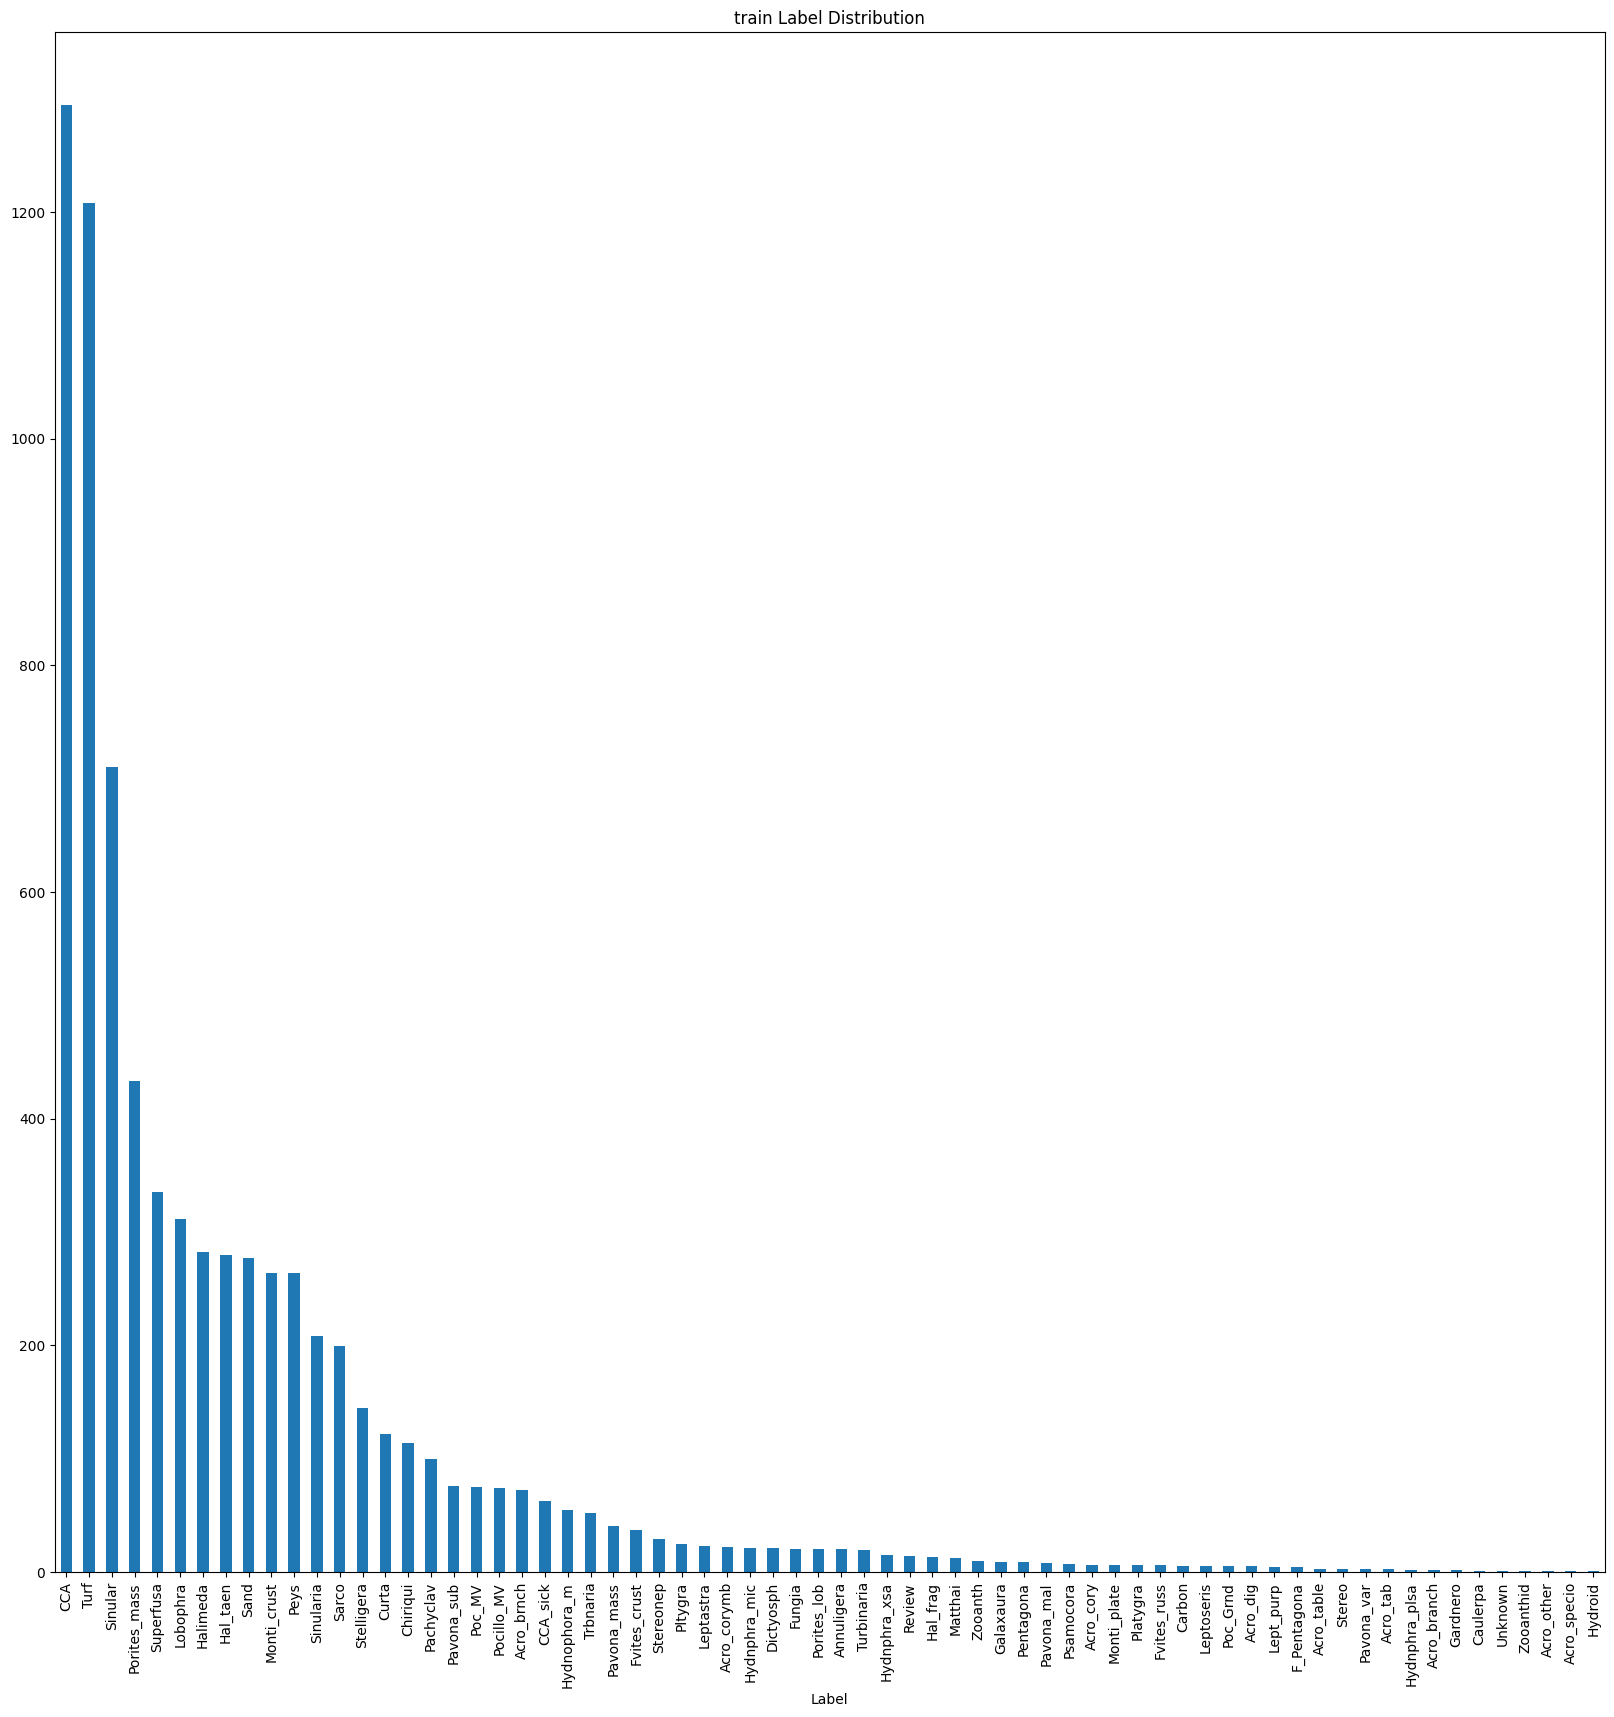

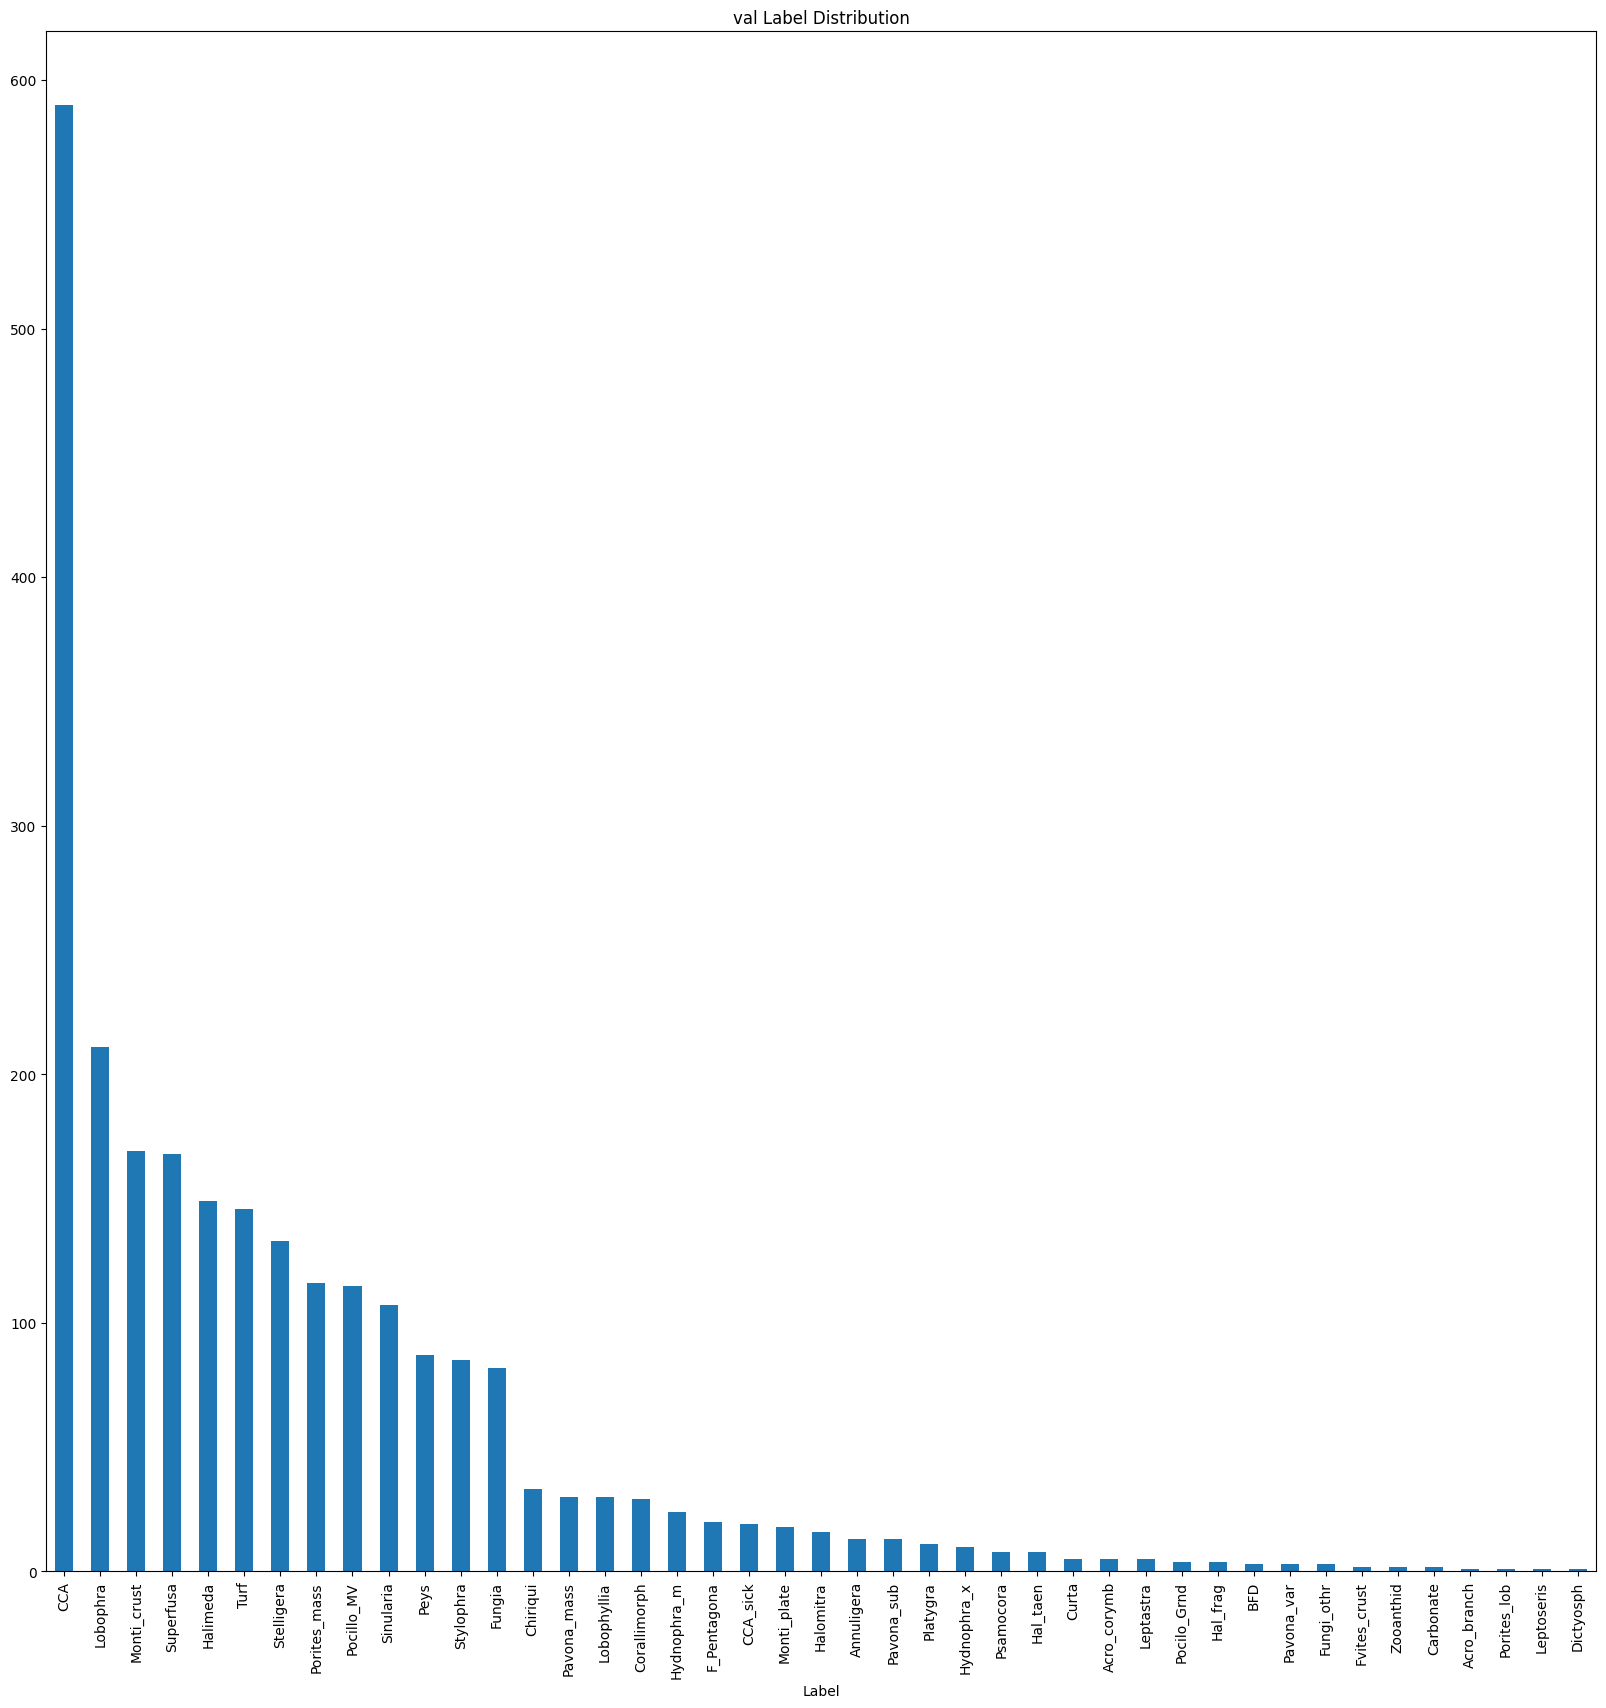

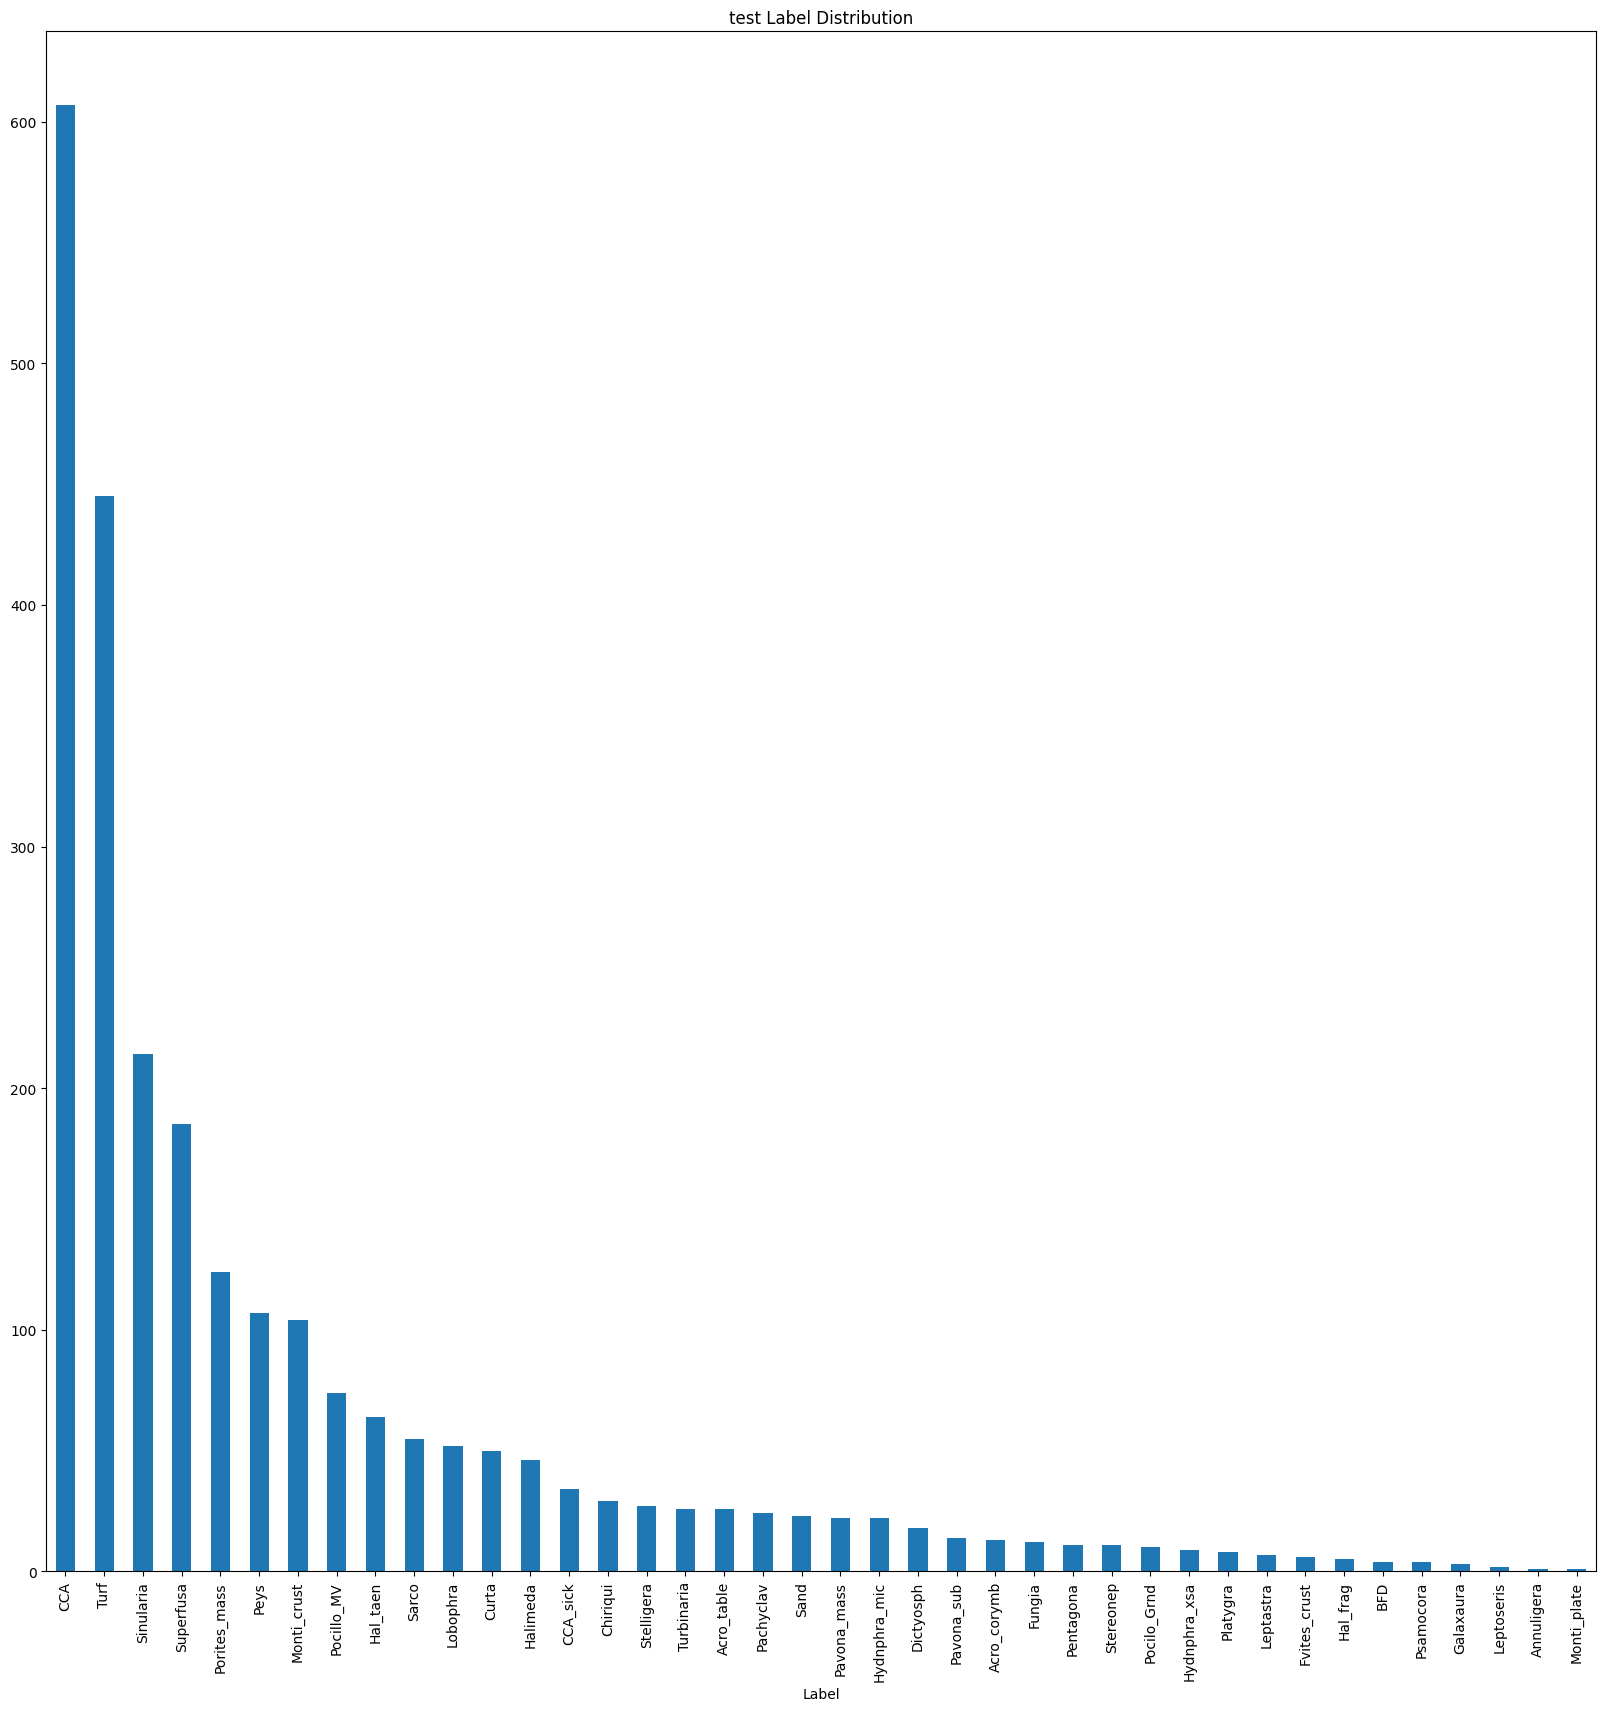

In [17]:
annotation_size = 512

class_labels = []

for site, data in tqdm(training_orthomosaic_data_dict.items(), desc="Filtering Training Point Data"):
    dataframe = filter_orthomosaic_csv_file(data['orthomosaic_point_file'])
    training_orthomosaic_data_dict[site]['dataframe'] = dataframe
    class_labels.extend(dataframe['Label'].unique())
    save_dataframe(dataframe, site, orthomosaic_filtered_dir)
    
for site, data in tqdm(validation_orthomosaic_data_dict.items(), desc="Filtering Validation Point Data"):
    dataframe = filter_orthomosaic_csv_file(data['orthomosaic_point_file'])
    validation_orthomosaic_data_dict[site]['dataframe'] = dataframe
    class_labels.extend(dataframe['Label'].unique())
    save_dataframe(dataframe, site, orthomosaic_filtered_dir)
        
for site, data in tqdm(testing_orthomosaic_data_dict.items(), desc="Filtering Testing Point Data"):
    dataframe = filter_orthomosaic_csv_file(data['orthomosaic_point_file'])
    testing_orthomosaic_data_dict[site]['dataframe'] = dataframe
    class_labels.extend(dataframe['Label'].unique())
    save_dataframe(dataframe, site, orthomosaic_filtered_dir)

class_labels = list(set(class_labels))
print(f"Num Class Labels: {len(class_labels)}")

print(f"Training Orthomosaic Dataframe: {sum([len(data['dataframe']) for data in training_orthomosaic_data_dict.values()])}")
print(f"Validation Orthomosaic Dataframe: {sum([len(data['dataframe']) for data in validation_orthomosaic_data_dict.values()])}")
print(f"Testing Orthomosaic Dataframe: {sum([len(data['dataframe']) for data in testing_orthomosaic_data_dict.values()])}")

# Create the class mapping JSON
orthomosaic_dataframes_combined = []

for site, data in training_orthomosaic_data_dict.items():
    orthomosaic_dataframes_combined.append(data['dataframe'])
    
for site, data in validation_orthomosaic_data_dict.items():
    orthomosaic_dataframes_combined.append(data['dataframe'])

for site, data in testing_orthomosaic_data_dict.items():
    orthomosaic_dataframes_combined.append(data['dataframe'])
    
orthomosaic_dataframes_combined = pd.concat(orthomosaic_dataframes_combined)
create_class_mapping_json(orthomosaic_dataframes_combined, orthomosaic_dataset_dir)

# Save the dataframes
plot_dataframes([data['dataframe'] for data in training_orthomosaic_data_dict.values()], "train", orthomosaic_dataset_dir)
plot_dataframes([data['dataframe'] for data in validation_orthomosaic_data_dict.values()], "val", orthomosaic_dataset_dir)
plot_dataframes([data['dataframe'] for data in testing_orthomosaic_data_dict.values()], "test", orthomosaic_dataset_dir)

# Create the datasets
for site, data in tqdm(training_orthomosaic_data_dict.items(), desc="Creating Training Dataset"):
    dataframe = data['dataframe']
    create_dataset([data['orthomosaic_file']], dataframe, annotation_size, class_labels, orthomosaic_dataset_dir, "train")
    
for site, data in tqdm(validation_orthomosaic_data_dict.items(), desc="Creating Validation Dataset"):
    dataframe = data['dataframe']
    create_dataset([data['orthomosaic_file']], dataframe, annotation_size, class_labels, orthomosaic_dataset_dir, "val")
    
for site, data in tqdm(testing_orthomosaic_data_dict.items(), desc="Creating Testing Dataset"):
    dataframe = data['dataframe']
    create_dataset([data['orthomosaic_file']], dataframe, annotation_size, class_labels, orthomosaic_dataset_dir, "test")

In [ ]:
print("Done.")